In [8]:
import polars as pl
import time
import math
import torch
import sys
sys.path.insert(0, './star-charts')
import sky_area
from star_data import StarData, StarDataList
from input_file import InputFile
from diagram import Diagram
from coord_calc import CoordCalc
from skyfield.api import position_of_radec, load_constellation_map, load_constellation_names
from skyfield.units import Angle


In [69]:
dftycho = pl.read_parquet('./support/tyc2-3.parquet')

In [56]:
def stars_for_point_and_radius(df, point, radius, max_mag):
    """ point is in the corner, not the center """
    ra, dec = point
    minra = ra
    maxra = ra + radius
    mindec = dec
    maxdec = dec + radius
    return df.filter((pl.col("RAmdeg") < maxra) & (pl.col("RAmdeg") > minra) & (pl.col("DEmdeg") < maxdec) & (pl.col("DEmdeg") > mindec) & (pl.col("Vmag") <= max_mag))

def get_grid_points(min_dec=-90, max_dec=90):
    RA_values = [ra for ra in range(0, 361, 4)]  # Increment by 4 for a 2-degree radius
    Dec_values = [dec for dec in range(min_dec, max_dec+1, 4)]  # Increment by 4 for a 2-degree radius
    grid_points = [(ra, dec) for ra in RA_values for dec in Dec_values]
    return grid_points
    oenuthoenutdd

def get_grid_point_by_idx(idx):
    gp = get_grid_points()
    return gp[idx]

def get_region(dftycho, idx, radius, min_dec, max_dec, max_mag):
    gp = get_grid_points(min_dec, max_dec)
    point = gp[idx]
    return stars_for_point_and_radius(dftycho, point, radius, max_mag)

def get_center(dftycho, center, radius, max_mag):
    return stars_for_point_and_radius(dftycho, center, radius, max_mag)

def draw_region(region, regionstars, focusstars, label):
    area  = sky_area.SkyArea(regionstars['RAmdeg'].min(),regionstars['RAmdeg'].max(), regionstars['DEmdeg'].min(), regionstars['DEmdeg'].max(), regionstars['Vmag'].min())
    print(str(area))
    star_data_list = [StarData(x[0], x[1], x[2]) for x in regionstars.rows()]
    for star in focusstars:
        star_data_list.append(StarData(star[0], star[1], star[2], label))
    star_data_list = StarDataList(star_data_list)
    
    cc = CoordCalc(star_data_list, area, 400)    
    cc.process()
    d = Diagram(f'Region {region}', area, star_data_list)
    list(map(d.add_curve, cc.calc_curves()))     
    d.render_svg(f'region_{region}.svg')

def ra_to_hms(ra):
    if ra < 0.0:
        ra = ra + 360
    mm, hh = math.modf(ra / 15.0)
    _, mm = math.modf(mm * 60.0)
    ss = round(_ * 60.0)
    return hh, mm, ss

In [11]:
result_filename = 'result_triangle2.parquet'
df = pl.read_parquet(result_filename)
print("length of parquet results:", len(df))


length of parquet results: 14381


# Enrich data with constellation

In [12]:
constellation_at = load_constellation_map()
con_full_names = dict(load_constellation_names())
con_full_names['CVn'] = 'Canes Venatici'
head = df.sort("score").head(100)


def get_mean(value):
    points = torch.tensor(value.to_list())
    mean = points.mean(dim=0)
    return points, mean

def process_stars(value):
    points, mean = get_mean(value)
    dec = mean[1]
    ra = Angle(degrees=mean[0].item())
    center = position_of_radec(ra._hours, dec)
    con = constellation_at(center)
    return con

def process_ra_h(value):
    points, mean = get_mean(value)
    ra = Angle(degrees=mean[0].item())
    return ra._hours

def process_dec_h(value):
    points, mean = get_mean(value)
    ra = Angle(degrees=mean[0].item())
    return ra.degrees
    
def process_ra_h_full(value):
    points, mean = get_mean(value)
    ra = Angle(degrees=mean[0].item())
    return ra.hstr(places=4, warn=False)

def process_dec_h_full(value):
    points, mean = get_mean(value)
    dec = Angle(degrees=mean[1].item())
    return dec.dstr(places=4, warn=False)
    
def full_names(short_name):
    return con_full_names[short_name]
    

# Add a new column to the DataFrame
head = head.with_columns(
    pl.col("stars").map_elements(process_ra_h, return_dtype=pl.Float64).alias("Rah")
)
# Add a new column to the DataFrame
head = head.with_columns(
    pl.col("stars").map_elements(process_dec_h, return_dtype=pl.Float64).alias("Dec")
)
head = head.with_columns(
    pl.col("stars").map_elements(process_ra_h_full, return_dtype=pl.Utf8).alias("Rah_full")
)
head = head.with_columns(
    pl.col("stars").map_elements(process_dec_h_full, return_dtype=pl.Utf8).alias("Dec_full")
)
# Add a new column to the DataFrame
head = head.with_columns(
    pl.col("stars").map_elements(process_stars, return_dtype=pl.Utf8).alias("CON")
)
head = head.with_columns(
    pl.col("CON").map_dict(con_full_names).alias("CONSTELLATION")
)

print(head)
#print(head.describe())
chosen = head[0]
chosen
print(chosen['Rah_full'][0])
print(chosen['Dec_full'][0])

shape: (100, 9)
┌──────────┬────────┬───────────────┬───────────┬───┬──────────┬──────────────┬─────┬──────────────┐
│ score    ┆ region ┆ stars         ┆ Rah       ┆ … ┆ Rah_full ┆ Dec_full     ┆ CON ┆ CONSTELLATIO │
│ ---      ┆ ---    ┆ ---           ┆ ---       ┆   ┆ ---      ┆ ---          ┆ --- ┆ N            │
│ f64      ┆ i64    ┆ list[list[f64 ┆ f64       ┆   ┆ str      ┆ str          ┆ str ┆ ---          │
│          ┆        ┆ ]]            ┆           ┆   ┆          ┆              ┆     ┆ str          │
╞══════════╪════════╪═══════════════╪═══════════╪═══╪══════════╪══════════════╪═════╪══════════════╡
│ 0.000034 ┆ 120    ┆ [[12.699203,  ┆ 0.883178  ┆ … ┆ 00h 52m  ┆ 33deg 37'    ┆ Psc ┆ Pisces       │
│          ┆        ┆ 33.301624,    ┆           ┆   ┆ 59.4415s ┆ 13.3694"     ┆     ┆              │
│          ┆        ┆ 9.2126],…     ┆           ┆   ┆          ┆              ┆     ┆              │
│ 0.000056 ┆ 690    ┆ [[85.193146,  ┆ 5.682183  ┆ … ┆ 05h 40m  ┆ 09deg 41' 

In [13]:
from skyfield.units import Angle
ra, dec = Angle(hours=5.5877286), Angle(degrees=-5.38731536)
print(ra, dec)


05h 35m 15.82s -05deg 23' 14.3"


In [52]:
#region = df.sort("score")[0]['region'][0]
region = int(chosen['region'][0])
print(region)
region_stars = get_region(dftycho, region, 4, -63,63, 15)
print(region_stars.describe())

120
shape: (9, 4)
┌────────────┬───────────┬───────────┬───────────┐
│ describe   ┆ RAmdeg    ┆ DEmdeg    ┆ Vmag      │
│ ---        ┆ ---       ┆ ---       ┆ ---       │
│ str        ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 768.0     ┆ 768.0     ┆ 768.0     │
│ null_count ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 14.021161 ┆ 35.118481 ┆ 11.155953 │
│ std        ┆ 1.181515  ┆ 1.153992  ┆ 1.123967  │
│ min        ┆ 12.000978 ┆ 33.008934 ┆ 5.98716   │
│ 25%        ┆ 13.00165  ┆ 34.124802 ┆ 10.573211 │
│ 50%        ┆ 13.991213 ┆ 35.157185 ┆ 11.405519 │
│ 75%        ┆ 15.032804 ┆ 36.162804 ┆ 11.983829 │
│ max        ┆ 15.999609 ┆ 36.984146 ┆ 13.63912  │
└────────────┴───────────┴───────────┴───────────┘


In [15]:
focusstars = chosen['stars'].to_list()[0]
print(focusstars)
draw_region(region, region_stars, focusstars, "a")

time.sleep(5)
!convert -size 800x600 region_{region}.svg region_{region}.png
!open region_{region}.png

[[12.699203491210938, 33.3016242980957, 9.212599754333496], [13.816502571105957, 33.352256774902344, 9.186579704284668], [13.227314949035645, 34.207252502441406, 9.603290557861328]]
SkyArea: ra_min=12.000978 ra_max=13.957239 dec_min=33.008934 dec_max=34.999302 mag_min=6.879860


In [16]:
def get_radec_minmax(region_stars):
    ramin = region_stars['RAmdeg'].min()
    ramax = region_stars['RAmdeg'].max()
    demin = region_stars['DEmdeg'].min()
    demax = region_stars['DEmdeg'].max()
    return ramin,ramax,demin, demax

In [19]:
from starplot import MapPlot, Projection, SkyObject
from starplot.styles import PlotStyle, extensions

def starplot_region(ramin, ramax, demin, demax, region_stars, points, filename):
    style = PlotStyle().extend(
        extensions.BLUE_LIGHT,
        extensions.MAP,
        {
            "bayer_labels": {
                "font_name": "Hack Nerd Font",  # use a better font for Greek letters
                "font_size": 7,
                "font_alpha": 0.9,
            },
        },
    )
    style.star.label.font_size = 11
    
    p = MapPlot(
        projection=Projection.MERCATOR,
        # ra_min=ramin,
        # ra_max=ramax,
        # dec_min=demin,
        # dec_max=demax,
        ra_min=12/15.0,
        ra_max=14/15.0,
        dec_min=33,
        dec_max=35,
        limiting_magnitude=12,
        style=style,
        resolution=3600,
    )
    # for point in region_stars:
    #     p.plot_object(
    #         SkyObject(
    #             name="b",
    #             ra=point[0]/15.0,
    #             dec=point[1],
    #             style={
    #                 "marker": {
    #                     "size": 10,
    #                     "symbol": ".",
    #                     "fill": "full",
    #                     "color": "#ff6868",
    #                     "alpha": 1,
    #                     "zorder": 4096,
    #                 },
    #                 "label": {
    #                     "font_size": 10,
    #                     "font_weight": "bold",
    #                     "font_color": "darkred",
    #                     "zorder": 4096,
    #                 },
    #             },
    #         )
    #     )
    # for point in points:
    #     p.plot_object(
    #         SkyObject(
    #             name="a",
    #             ra=point[0]/15.0,
    #             dec=point[1],
    #             style={
    #                 "marker": {
    #                     "size": 10,
    #                     "symbol": ".",
    #                     "fill": "full",
    #                     "color": "#ff6868",
    #                     "alpha": 1,
    #                     "zorder": 4096,
    #                 },
    #                 "label": {
    #                     "font_size": 10,
    #                     "font_weight": "bold",
    #                     "font_color": "darkred",
    #                     "zorder": 4096,
    #                 },
    #             },
    #         )
    #    )
    p.export(filename, padding=0.5)


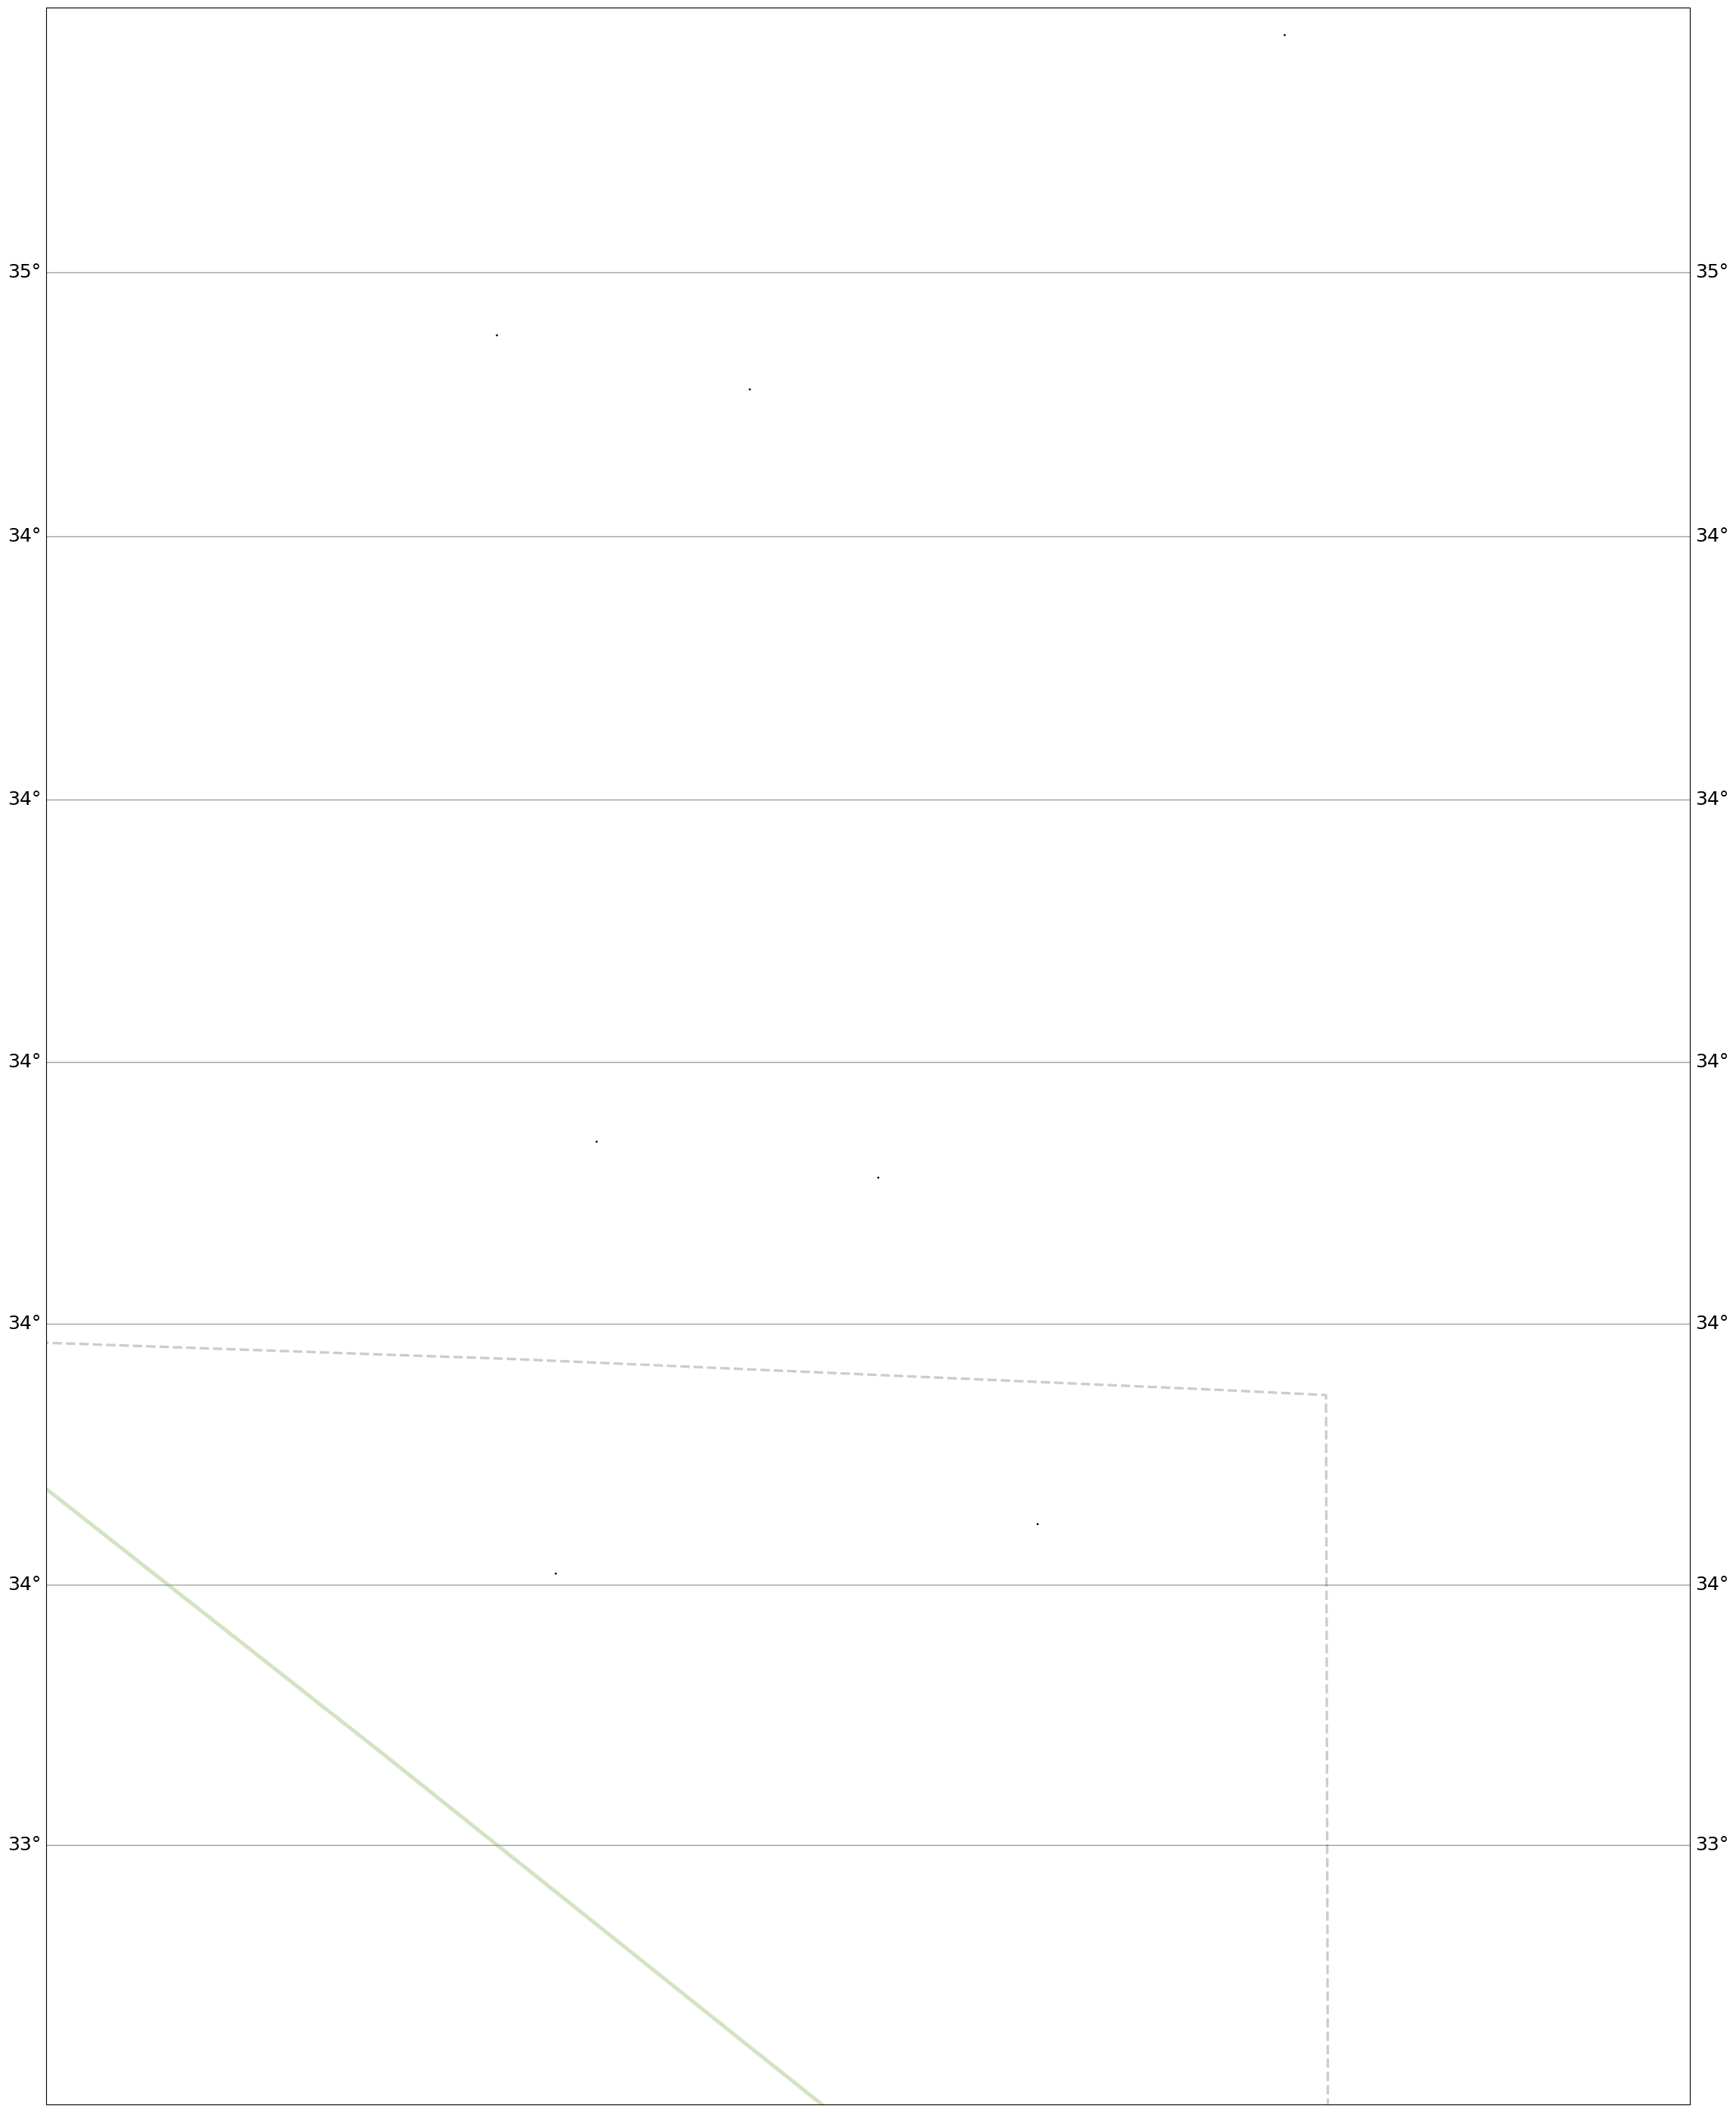

In [20]:
starplot_region(*get_radec_minmax(region_stars), region_stars, focusstars, 'test.png')

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_degrees', '_hours', 'arcminutes', 'arcseconds', 'degrees', 'dms', 'dstr', 'from_degrees', 'hms', 'hours', 'hstr', 'mas', 'preference', 'radians', 'signed', 'signed_dms', 'signed_hms', 'to']
0.008726867790758753


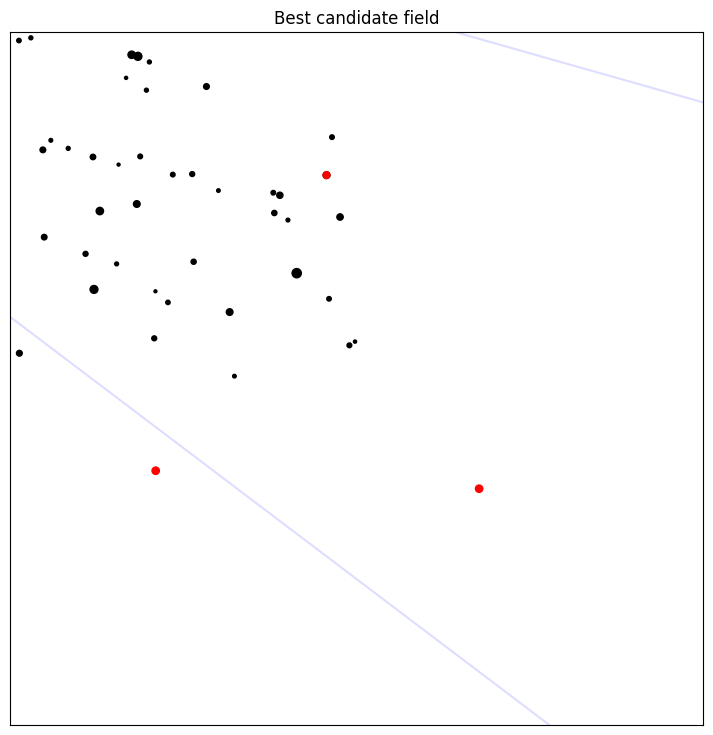

In [68]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection
import pandas

# The comet is plotted on several dates `t_comet`.  But the stars only
# need to be drawn once, so we take the middle comet date as the single
# time `t` we use for everything else.

ts = load.timescale()
t = ts.utc(2023, 7, 27)

# An ephemeris from the JPL provides Sun and Earth positions.

eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']
looking_at = Star(ra_hours=(0, 52, 29.4415),
               dec_degrees=(33, 37, 13.3694))

# The Minor Planet Center data file provides the comet orbit.

# The Hipparcos mission provides our star catalog.

with load.open(hipparcos.URL) as f:
    stars = hipparcos.load_dataframe(f)

# And the constellation outlines come from Stellarium.  We make a list
# of the stars at which each edge stars, and the star at which each edge
# ends.

url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/modern_st/constellationship.fab')

with load.open(url) as f:
    constellations = stellarium.parse_constellations(f)

edges = [edge for name, edges in constellations for edge in edges]
edges_star1 = [star1 for star1, star2 in edges]
edges_star2 = [star2 for star1, star2 in edges]

# We will center the chart on the comet's middle position.

center = earth.at(t).observe(looking_at)
print(dir(looking_at.ra))
region_stars = get_center(dftycho, (looking_at.ra._degrees, looking_at.dec.degrees), 2, 15)
projection = build_stereographic_projection(center)
field_of_view_degrees = 2.0
limiting_magnitude = 14.0

# Now that we have constructed our projection, compute the x and y
# coordinates that each star and the comet will have on the plot.

star_positions = earth.at(t).observe(Star.from_dataframe(stars))
stars['x'], stars['y'] = projection(star_positions)

# Create a True/False mask marking the stars bright enough to be
# included in our plot.  And go ahead and compute how large their
# markers will be on the plot.

bright_stars = (stars.magnitude <= limiting_magnitude)
magnitude = stars['magnitude'][bright_stars]
marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0

# The constellation lines will each begin at the x,y of one star and end
# at the x,y of another.  We have to "rollaxis" the resulting coordinate
# array into the shape that matplotlib expects.

xy1 = stars[['x', 'y']].loc[edges_star1].values
xy2 = stars[['x', 'y']].loc[edges_star2].values
lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)

# Time to build the figure!

fig, ax = plt.subplots(figsize=[9, 9])

# Draw the constellation lines.

ax.add_collection(LineCollection(lines_xy, colors='#00f2'))

# Draw the stars.

def draw_points(stars, limiting_magnitude, color):
    fs=pandas.DataFrame(stars, columns=['ra_hours', 'dec_degrees', 'magnitude'])
    fs['ra_hours'] = fs['ra_hours'] / 15
    fs['epoch_year']=2000
    focusstar_positions = earth.at(t).observe(Star.from_dataframe(fs))
    fs['x'], fs['y'] = projection(focusstar_positions)
    magnitude = fs['magnitude']
    marker_size2 = (0.5 + limiting_magnitude - magnitude) ** 2.0
    ax.scatter(fs['x'], fs['y'], s=marker_size2, color=color)

draw_points(region_stars, limiting_magnitude, 'k')
draw_points(focusstars, limiting_magnitude, 'r')
    
# Draw the comet positions, and label them with dates.

offset = 0.002

# Finally, title the plot and set some final parameters.

angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))
print(limit)

ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect(1.0)
ax.set_title('Best candidate field')

# Save.

fig.savefig('neowise-finder-chart.png', bbox_inches='tight')